# Brain Tumor Classification
Building a detection model using a convolutional neural network (CNN) in Tensorflow & Keras.
We used brain MRI images data founded on Kaggle. 

In [ ]:
import cv2
import os
import sklearn
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import keras
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Data Preparation & Pre-Processing
1. Resizing images: Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (160, 160, 3) to feed it as an input to the neural network.
2. Apply normalization because we want pixel values to be scaled to the range 0-1.
3. Data Augmentation: Since this is a small dataset, there wasn't enough data to train the neural network model. Also, data augmentation is useful in addressing the data imbalance issue in the data. 
4. Visualizing Samples

Loading complete for training and testing dataset


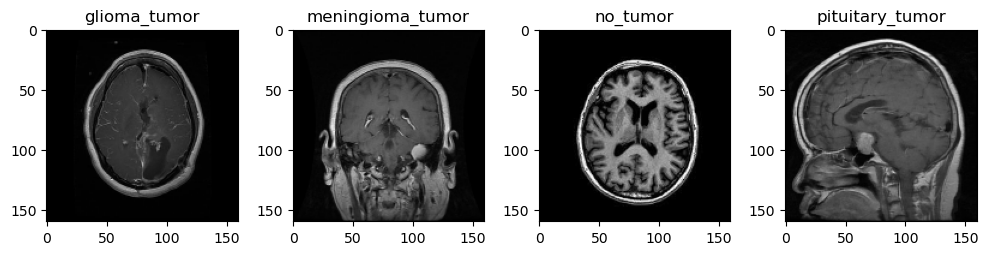

In [41]:
LOCATION = "/kaggle/input/brain-tumor-classification-mri/"
TYPE = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Constants
IMAGE_SIZE = 160
BATCH_SIZE = 11
VERBOSE = 1

# Loading Training Datasets from folders
x_train = []
y_train = []
for i in TYPE:
    path = os.path.join(os.path.join(LOCATION, "Training"), i)
    for j in os.listdir(path):
        img = cv2.imread(os.path.join(path, j))
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)

for m in TYPE:
    path = os.path.join(os.path.join(LOCATION, "Testing"), i)
    for n in os.listdir(path):
        img = cv2.imread(os.path.join(path, n))
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(m)
print("Loading complete for training and testing dataset")
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)


# Plotting a sample image from each class in a subplot grid of 4
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 4))
for i, class_name in enumerate(TYPE):
    for j in range(len(y_train)):
        if y_train[j] == class_name:
            ax[i].imshow(x_train[j])
            ax[i].set_title(class_name)
            break
plt.tight_layout()
plt.show()

# Data Augmentation
aug = ImageDataGenerator(rotation_range=7,zoom_range=0.1,width_shift_range=0.05,
                        height_shift_range=0.05,horizontal_flip=True,
                        fill_mode="nearest")

# Model Training 1
Splitting, building and tarining using Xception Model

In [ ]:
train_size = 0.90
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=1 - train_size, random_state=47)

#One-hot encoding for labels
y_train = tf.keras.utils.to_categorical([TYPE.index(i) for i in y_train])
y_test = tf.keras.utils.to_categorical([TYPE.index(i) for i in y_test])


def modelXception():
    #Using the Xception Model
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    xception = Xception(weights="imagenet", input_shape=input_shape, include_top=False)

    # Adding the layers of Neural Network
    model = xception.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    model = tf.keras.layers.Dense(len(TYPE), activation="softmax")(model)
    model = tf.keras.models.Model(inputs=xception.input, outputs=model)
    
    # Compiling and fitting the model
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
    history = model.fit(aug.flow(x_train, y_train, batch_size=BATCH_SIZE), validation_data=(x_test, y_test),
                        steps_per_epoch=len(x_train) // BATCH_SIZE,epochs=15)

    # Plotting the training and validation accuracy and loss
    fig, ax = plt.subplots(1, 2)
    train_acc = history.history["accuracy"]
    train_loss = history.history["loss"]
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]
    fig.set_size_inches(14, 7)

    ax[0].plot(range(len(train_acc)), train_acc, "go-", label="Training Accuracy")
    ax[0].plot(range(len(val_acc)), val_acc, "ro-", label="Validation Accuracy")
    ax[0].set_title("Training & Validation Accuracy")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(range(len(train_loss)), train_loss, "g-o", label="Training Loss")
    ax[1].plot(range(len(val_loss)), val_loss, "r-o", label="Validation Loss")
    ax[1].set_title("Testing Accuracy & Loss")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()
    
    
    # Evaluating Model
    result = model.evaluate(x_test, y_test)
    print("Testing Loss :", result[0])
    print("Testing Accuracy :", result[1]*100, "%")
    
    predictions = model.predict(x_test)
    predictions = np.argmax(predictions, axis = 1)
    y_test_edit = np.argmax(y_test , axis = 1)
    
    cf_report = sklearn.metrics.classification_report(y_test_edit, predictions)
    print(cf_report)
    
    
    cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions)
    sns.heatmap(cf_matrix, cmap = 'Greens', linewidth = 1, annot = True, xticklabels=class_names, yticklabels=class_names)
    

# Model Training 2
Splitting, building and tarining using EfficientNetV2S

In [42]:
aug.fit(x_train)
x_train.shape
lb = LabelEncoder()

train_size = 0.90
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=1 - train_size, random_state=47,stratify = y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

def modelEfficientNet():
    
    
    
    #load EfficientNet
    EfficientNet=EfficientNetV2S(weights='imagenet', include_top=False,input_shape=(IMAGE_SIZE, IMAGE_SIZE,3))
    tf.random.set_seed(45)
    model = EfficientNet.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.5)(model)
    model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
    model = tf.keras.layers.Dropout(rate=0.3)(model)
    model = tf.keras.layers.Dense(4,activation='softmax')(model)
    model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
    opt = Adam(learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,epsilon=1e-08)

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    
    # # summarize the model
    # print(model.summary())
    
    # fit the model
    early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)
    history=model.fit(x_train ,y_train,validation_data = (x_test,y_test),epochs=100, batch_size=13,callbacks=early_stopping_cb)
    
    #plot loss and accuracy
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    #plt.grid(True)

    #plt.gca().set_xlim(0,33)
    plt.gca().set_ylim(0,1)
    plt.savefig('/kaggle/working/EfficientNetB3.png')
    plt.grid()
    plt.title('Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('MOP')
    loss, accuracy = model.evaluate(x_test,y_test)

    #print accuracy    
    print('Accuracy: %f' % (accuracy*100))
    
    loss, accuracy = model.evaluate(x_test,y_test)

# Accuracy Results and Plots

82420632/82420632 [==============================] - 0s 0us/step
Epoch 1/100
220/220 [==============================] - 47s 123ms/step - loss: 1.2474 - accuracy: 0.4314 - val_loss: 0.8797 - val_accuracy: 0.6972
Epoch 2/100
220/220 [==============================] - 23s 105ms/step - loss: 0.9005 - accuracy: 0.6486 - val_loss: 0.6646 - val_accuracy: 0.7886
Epoch 3/100
220/220 [==============================] - 23s 104ms/step - loss: 0.7160 - accuracy: 0.7290 - val_loss: 0.5207 - val_accuracy: 0.8139
Epoch 4/100
220/220 [==============================] - 23s 106ms/step - loss: 0.5964 - accuracy: 0.7838 - val_loss: 0.4423 - val_accuracy: 0.8391
Epoch 5/100
220/220 [==============================] - 23s 105ms/step - loss: 0.5360 - accuracy: 0.7996 - val_loss: 0.3986 - val_accuracy: 0.8423
Epoch 6/100
220/220 [==============================] - 23s 105ms/step - loss: 0.4578 - accuracy: 0.8350 - val_loss: 0.3644 - val_accuracy: 0.8517
Epoch 7/100
220/220 [==============================] - 23s 

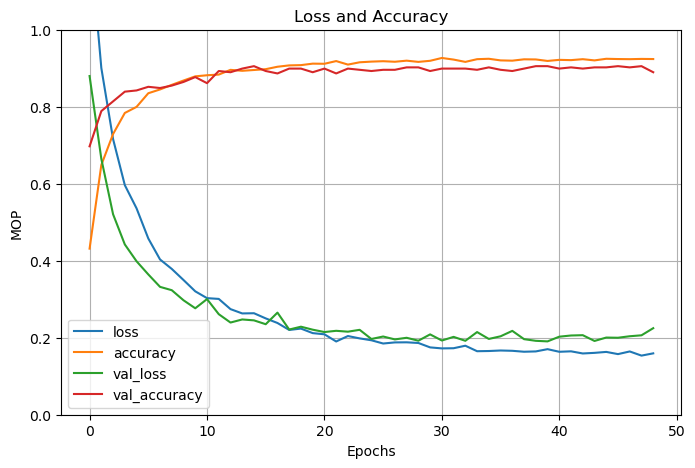

In [43]:
if __name__ == '__main__':
    # modelXception()
    modelEfficientNet()

# Conclusion:
The model-2 detects brain tumor with:

90.54% accuracy on the test set.